Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Taking necessary actions to read the data

### Importing all the important libraries

In [43]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [44]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [45]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = Path('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [46]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [47]:
data_dir_train

WindowsPath('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [48]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [49]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split the data into 80% training and 20% validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to 180x180
    batch_size=batch_size  # Number of images to return in each batch
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [50]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split the data into 80% training and 20% validation
    subset="validation",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to 180x180
    batch_size=batch_size  # Number of images to return in each batch
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [51]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### To visualize one instance of all the nine classes present in the dataset

In [52]:
images_per_class = {class_name: None for class_name in class_names}
print(images_per_class)

{'actinic keratosis': None, 'basal cell carcinoma': None, 'dermatofibroma': None, 'melanoma': None, 'nevus': None, 'pigmented benign keratosis': None, 'seborrheic keratosis': None, 'squamous cell carcinoma': None, 'vascular lesion': None}


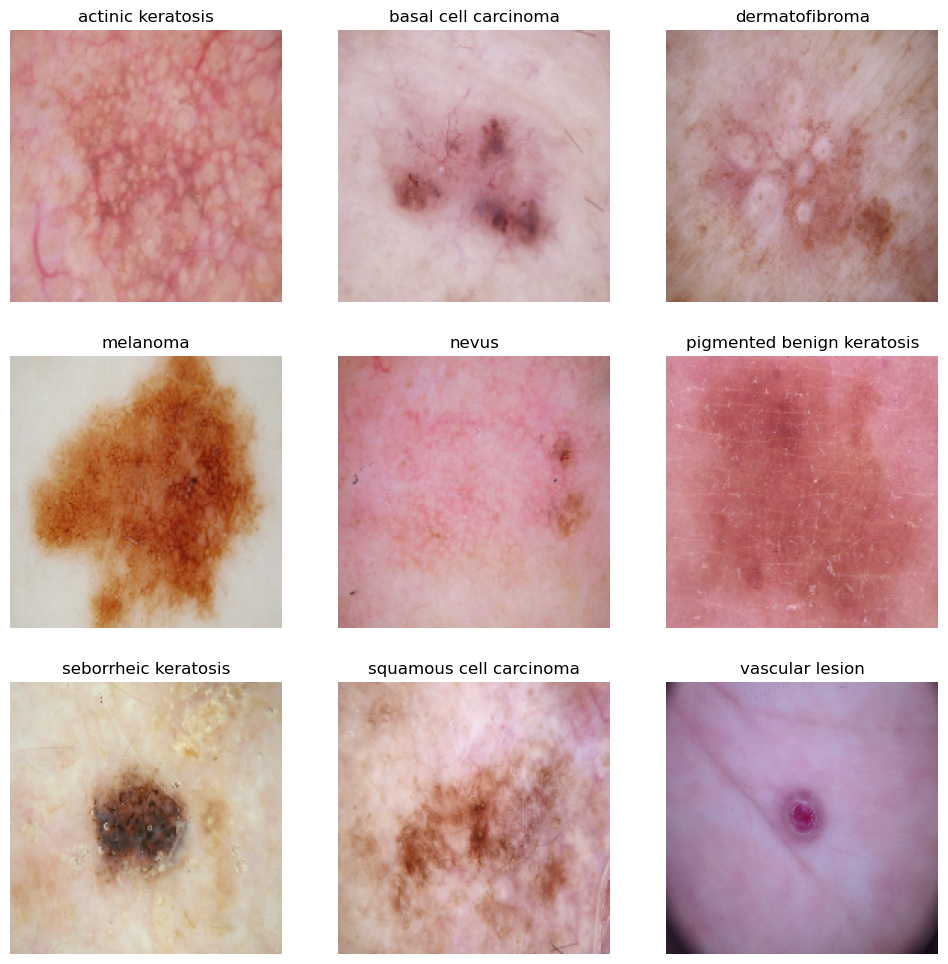

In [53]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
# Create a dictionary to store one image for each class
images_per_class = {class_name: None for class_name in class_names}

# Flag to check if all classes have been collected
all_classes_collected = False

# Iterate over the dataset to extract one image per class
for image_batch, labels_batch in train_ds:
    for img, label in zip(image_batch, labels_batch):
        class_name = class_names[label]
        if images_per_class[class_name] is None:
            images_per_class[class_name] = img.numpy()
        if all(value is not None for value in images_per_class.values()):
            all_classes_collected = True
            break
    if all_classes_collected:
        break


# Plot one instance of each class
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_per_class[class_name].astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
import tensorflow as tf
print(tf.__version__)  # Check TensorFlow version
print(tf.keras.__version__)  # Check Keras version bundled with TensorFlow

2.17.0
3.4.1


### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [56]:
# Define input shape based on your dataset
input_shape = (img_height, img_width, 3)  # Update this if your images have a different shape

# Create the model
model = models.Sequential([
#    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [57]:
### choosing an appropirate optimiser and loss function
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [58]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [59]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 672ms/step - accuracy: 0.2121 - loss: 2.0593 - val_accuracy: 0.2864 - val_loss: 1.8405
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 520ms/step - accuracy: 0.3045 - loss: 1.8765 - val_accuracy: 0.3602 - val_loss: 1.7929
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.4019 - loss: 1.6707 - val_accuracy: 0.3490 - val_loss: 1.7268
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 438ms/step - accuracy: 0.4217 - loss: 1.5925 - val_accuracy: 0.4944 - val_loss: 1.4751
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.4549 - loss: 1.5375 - val_accuracy: 0.4653 - val_loss: 1.5307
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.4913 - loss: 1.4246 - val_accuracy: 0.5145 - val_loss: 1.4754
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step - accuracy: 0.5250 - loss: 1.3320 - val_accuracy: 0.5235 - val_loss: 1.4324
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 449ms/step - accuracy: 0.5266 - loss: 1.3385 - val_accuracy: 0.521

### Visualizing training results

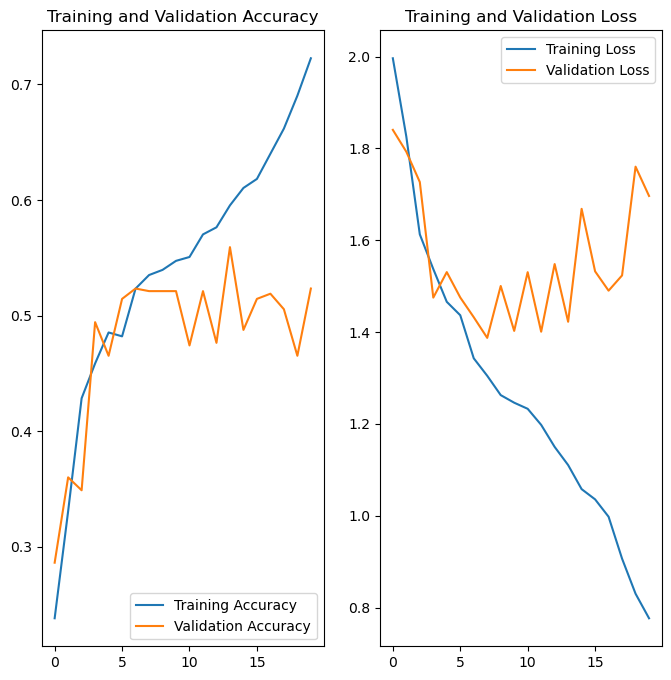

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### My findings is given below

Training accuracy (0.7348) is higher than validation accuracy (0.5391).
Training loss (0.7299) is lower than validation loss (1.7040).
This suggests that our model might be overfitting, as it performs better on the training data than on the validation data.

In [61]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2)
])


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


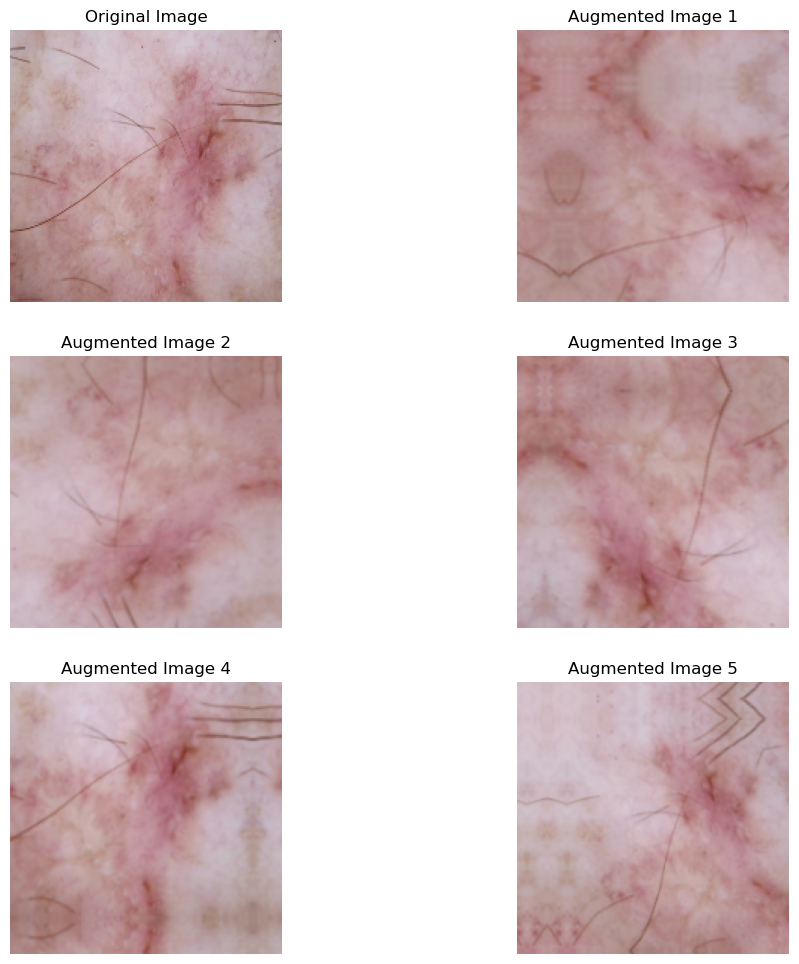

In [62]:
# visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Load a sample image from the dataset
def load_sample_image(data_augmentation, img_height, img_width):
    # Create a dataset to load a single image
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_augmentation,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=1  # Load one image at a time
    )
    # Get one image and its label
    for image, label in ds.take(1):
        return image[0], label[0]

# Function to visualize the augmentation
def visualize_augmentation(image):
    # Expand dimensions for batch
    image = tf.expand_dims(image, 0)

    # Apply data augmentation
    augmented_images = [data_augmentation(image, training=True)[0] for _ in range(5)]

    # Plot the original and augmented images
    plt.figure(figsize=(12, 12))

    # Plot the original image
    plt.subplot(3, 2, 1)
    plt.title('Original Image')
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.axis('off')

    # Plot augmented images
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(3, 2, i + 2)
        plt.title(f'Augmented Image {i+1}')
        plt.imshow(aug_img.numpy().astype("uint8"))
        plt.axis('off')

    plt.show()

# Set parameters
dataset_dir = data_dir_train  # Replace with your dataset directory
img_height = 180
img_width = 180

# Load a sample image
sample_image, _ = load_sample_image(dataset_dir, img_height, img_width)

# Visualize the augmentation strategy
visualize_augmentation(sample_image)

### Creating the model, compile and train the model

In [63]:
## I used Dropout layer as we see the overfitting in my findings

# Define the model with data augmentation
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    data_augmentation,  # Apply data augmentation
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])



c:\Users\PRITAM MUKHERJEE\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compiling the model

In [64]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [65]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 579ms/step - accuracy: 0.1721 - loss: 2.2916 - val_accuracy: 0.1924 - val_loss: 2.0468
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.2354 - loss: 2.0093 - val_accuracy: 0.3557 - val_loss: 1.8435
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.2785 - loss: 1.8557 - val_accuracy: 0.3848 - val_loss: 1.7880
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 567ms/step - accuracy: 0.3553 - loss: 1.7260 - val_accuracy: 0.3848 - val_loss: 1.6695
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.3466 - loss: 1.7726 - val_accuracy: 0.4228 - val_loss: 1.6290
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 567ms/step - accuracy: 0.4242 - loss: 1.5812 - val_accuracy: 0.3848 - val_loss: 1.6958
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.4470 - loss: 1.5702 - val_accuracy: 0.3758 - val_loss: 1.7331
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.4290 - loss: 1.6296 - val_accu

### Visualizing the results

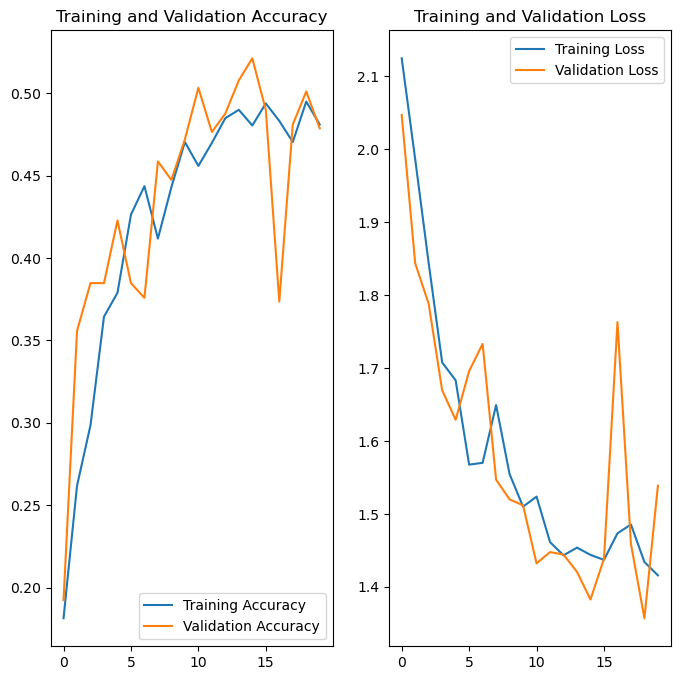

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

ANS - After Agmentation overfit issue is now solved but model accuracy has significantly redeced.

#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.


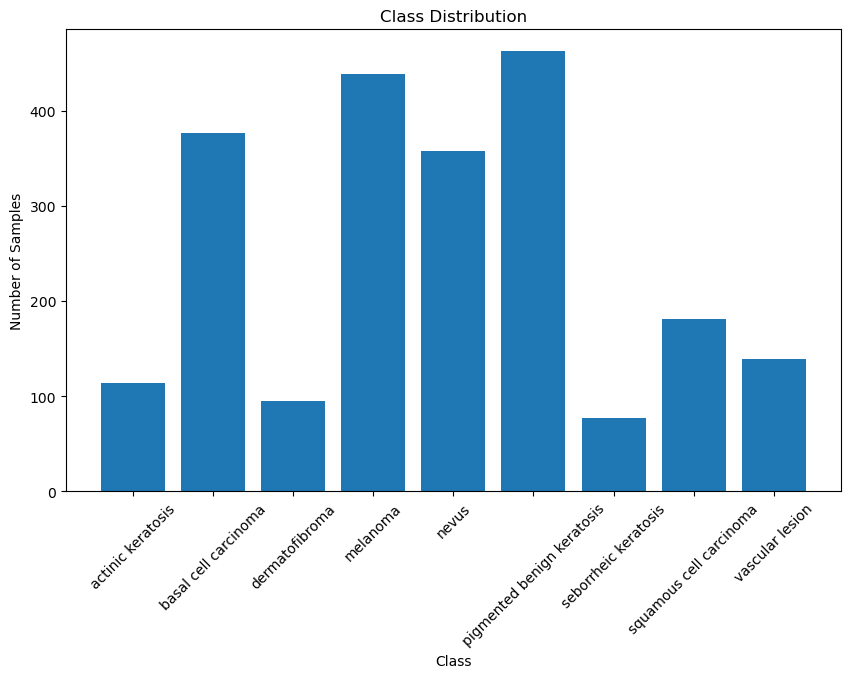

In [67]:
def plot_class_distribution(data_augmentation, img_height, img_width):
    # Load the dataset
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_augmentation,
        image_size=(img_height, img_width),
        batch_size=1,  # Load one image at a time
        shuffle=False
    )

      # Initialize class counts
    class_names = dataset.class_names
    class_counts = {class_name: 0 for class_name in class_names}


    # Count the number of images per class
    for images, labels in dataset:
        # Labels are in a batch, so we get the first item
        labels = labels.numpy().astype(int)
        for label in labels:
            class_name = class_names[label]
            class_counts[class_name] += 1

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

# Set parameters
dataset_dir = data_dir_train  # Replace with your dataset directory
img_height = 180
img_width = 180

# Plot class distribution
plot_class_distribution(dataset_dir, img_height, img_width)

#### Write your findings here: 
#### - Which class has the least number of samples?
ANS -> Seborrheic Keratosis 
#### - Which classes dominate the data in terms proportionate number of samples?
ANS -> Pigmented benign keratosis


#### Rectify the class imbalance
#### You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    class_path = (path_to_training_dataset / i)
    if not class_path.is_dir():
        print(f"Warning: The directory {class_path} does not exist.")
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21867C908D0>: 100%|██████████| 500/500 [00:06<00:00, 80.00 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2183C79CED0>: 100%|██████████| 500/500 [00:05<00:00, 84.58 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2183C5D6D10>: 100%|██████████| 500/500 [00:06<00:00, 80.71 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2183A7530D0>: 100%|██████████| 500/500 [00:33<00:00, 14.92 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x218004A6D10>: 100%|██████████| 500/500 [00:28<00:00, 17.47 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2183C6C3D90>: 100%|██████████| 500/500 [00:05<00:00, 83.63 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2183C79DFD0>: 100%|██████████| 500/500 [00:13<00:00, 35.87 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2183AD31BD0>: 100%|██████████| 500/500 [00:05<00:00, 84.29 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2183C90C1D0>: 100%|██████████| 500/500 [00:05<00:00, 85.03 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [69]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2207f5da-3d0b-4273-9d0d-68a1ccd53ff0.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_48acf86d-37b6-4bef-a821-12ec25cf2b53.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9c0c1e01-0cf4-4df5-a4b4-476529913171.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f9e6c6f6-4d94-4f8e-9fbc-4c62cdde3499.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ffe9a25d-43dd-482a-955c-738f509a3

In [71]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [72]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [73]:
dataframe_dict_new

{'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2207f5da-3d0b-4273-9d0d-68a1ccd53ff0.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_48acf86d-37b6-4bef-a821-12ec25cf2b53.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9c0c1e01-0cf4-4df5-a4b4-476529913171.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f9e6c6f6-4d94-4f8e-9fbc-4c62cdde3499.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\o

In [74]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [75]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [123]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [124]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [125]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating ythe model (include normalization)

In [126]:
## your code goes here
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])

c:\Users\PRITAM MUKHERJEE\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### Compiling the model (Choose optimizer and loss function appropriately)

In [127]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [128]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 683ms/step - accuracy: 0.1721 - loss: 2.1946 - val_accuracy: 0.2814 - val_loss: 1.8065
Epoch 2/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 120s 707ms/step - accuracy: 0.2846 - loss: 1.7869 - val_accuracy: 0.3823 - val_loss: 1.6536
Epoch 3/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 706ms/step - accuracy: 0.3785 - loss: 1.6042 - val_accuracy: 0.4195 - val_loss: 1.5250
Epoch 4/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 116s 688ms/step - accuracy: 0.4229 - loss: 1.4997 - val_accuracy: 0.4447 - val_loss: 1.4481
Epoch 5/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 701ms/step - accuracy: 0.4276 - loss: 1.4578 - val_accuracy: 0.4514 - val_loss: 1.3982
Epoch 6/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 120s 711ms/step - accuracy: 0.4556 - loss: 1.3711 - val_accuracy: 0.4863 - val_loss: 1.3313
Epoch 7/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 701ms/step - accuracy: 0.4956 - loss: 1.2966 - val_accuracy: 0.5033 - val_loss: 1.2590
Epoch 8/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 121s 717ms/step - accuracy: 0.5255 -

#### Visualize the model results

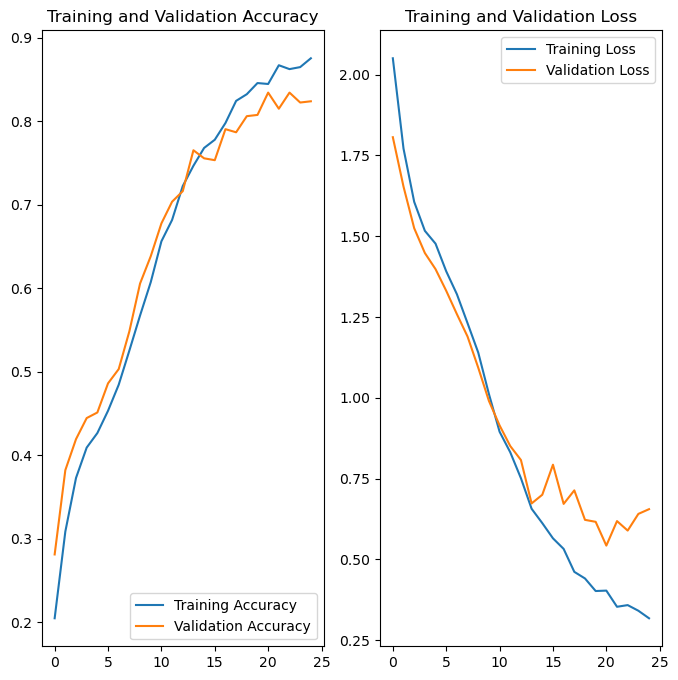

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Deleting Output folder for next successful run

In [131]:
import shutil
for name in class_names:
   path = os.path.join(data_dir_train,name,'output')
   if os.path.isdir(path):
       shutil.rmtree(path)

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



With the initial model built on train data, we could see overfitting. Adding an augmentations layer along with the dropouts after convulations helped in getting rid of overfitting in the final model.

After the first augmentation, we could see the accuracy was quite low even though overfitting was addressed.Reason being class imbalance in the training sample. If we plot the count of sample we have for all the subclasses, the difference is evident. Therefore, we created 500 samples of each class with another layer of augmentation.
Combining all of them, we could see a balanced accuracy with no overfit. 